In [1]:
import math
import os
from unified_planning.shortcuts import *

from up_spiderplan.solver import EngineImpl
from up_spiderplan.util import plot_path

# Movavle Type and Robots

First, we create a movable type and two robot objects. Each robot has a footprint to indicate its shape, a motion model (here a Reeds Shepp car), and a list of parameters required by the motion model (here the turning radius of the Reeds Shepp car).

In [2]:
t_robot = MovableType("robot")

r1 = MovableObject(
    "r1",
    t_robot,
    footprint=[(-1.0, 0.5), (1.0, 0.5), (1.0, -0.5), (-1.0, -0.5)],
    motion_model=MotionModels.REEDSSHEPP,
    parameters={"turning_radius": 2.0},
)

r2 = MovableObject(
    "r2",
    t_robot,
    footprint=[(-1.0, 0.5), (1.0, 0.5), (1.0, -0.5), (-1.0, -0.5)],
    motion_model=MotionModels.REEDSSHEPP,
    parameters={"turning_radius": 2.0},
)

# Occupancy Map and Configurations

Now we create an occupancy map and a configuration type that links symbolic locations to robot poses in the map. We then create two parking positions for the robot and one location for each office.

In [3]:
occ_map = OccupancyMap(os.path.join("./maps/", "office-map-1.yaml"), (0, 0))

t_robot_config = ConfigurationType("robot_config", occ_map, 3)

park1 = ConfigurationObject("parking-1", t_robot_config, (46.0, 26.0, 3*math.pi/2))
park2 = ConfigurationObject("parking-2", t_robot_config, (40.0, 26.0, 3*math.pi/2))

office1 = ConfigurationObject("office-1", t_robot_config, (4.0, 4.0, 3*math.pi/2))
office2 = ConfigurationObject("office-2", t_robot_config, (14.0, 4.0, math.pi/2))
office3 = ConfigurationObject("office-3", t_robot_config, (24.0, 4.0, 3*math.pi/2))
office4 = ConfigurationObject("office-4", t_robot_config, (32.0, 4.0, 3*math.pi/2))
office5 = ConfigurationObject("office-5", t_robot_config, (4.0, 24.0, 3*math.pi/2))
office6 = ConfigurationObject("office-6", t_robot_config, (14.0, 24.0, math.pi/2))
office7 = ConfigurationObject("office-7", t_robot_config, (24.0, 24.0, math.pi/2))
office8 = ConfigurationObject("office-8", t_robot_config, (32.0, 24.0, math.pi/2))

# Another Type and Some Fluents

We create another type with some objects and some fluents needed by our operators. 

In [4]:
t_parcel = UserType("parcel")
nothing = Object("nothing", t_parcel)
p1 = Object("parcel-1", t_parcel)
p2 = Object("parcel-2", t_parcel)

robot_at = Fluent("robot_at", BoolType(), robot=t_robot, configuration=t_robot_config)
parcel_at = Fluent("parcel_at", BoolType(), parcel=t_parcel, configuration=t_robot_config)
carries = Fluent("carries", BoolType(), robot=t_robot, parcel=t_parcel)

# Move Operator

The move operator moves a robot from one location to another. To include the motion requirement, we add a motion constraints that requires the robot to find a path from `c_from` to `c_to`.

In [5]:
move = InstantaneousMotionAction(
    "move", robot=t_robot, c_from=t_robot_config, c_to=t_robot_config
)
robot = move.parameter("robot")
c_from = move.parameter("c_from")
c_to = move.parameter("c_to")
move.add_precondition(robot_at(robot, c_from))
move.add_effect(robot_at(robot, c_from), False)
move.add_effect(robot_at(robot, c_to), True)

move.add_motion_constraint(Waypoints(robot, c_from, [c_to]))

# Pick Operator

The pick operator allows the robot to pickup a parcel at its current location if it carries nothing.

In [6]:
pick = InstantaneousMotionAction(
    "pick", robot=t_robot, loc=t_robot_config, parcel=t_parcel
)
pick_robot = pick.parameter("robot")
pick_loc = pick.parameter("loc")
pick_parcel = pick.parameter("parcel")
pick.add_precondition(robot_at(pick_robot, pick_loc))
pick.add_precondition(parcel_at(pick_parcel, pick_loc))
pick.add_precondition(carries(pick_robot, nothing))
pick.add_precondition(Not(carries(pick_robot, pick_parcel)))
pick.add_effect(carries(pick_robot, pick_parcel), True)
pick.add_effect(parcel_at(pick_parcel, pick_loc), False)
pick.add_effect(carries(pick_robot, nothing), False)

# Place Operator

The place operator places a parcel carried by the robot at a location.

In [7]:
place = InstantaneousMotionAction(
    "place", robot=t_robot, loc=t_robot_config, parcel=t_parcel
)
place_robot = place.parameter("robot")
place_loc = place.parameter("loc")
place_parcel = place.parameter("parcel")
place.add_precondition(robot_at(place_robot, place_loc))
place.add_precondition(carries(place_robot, place_parcel))
place.add_precondition(Not(parcel_at(place_parcel, place_loc)))
place.add_precondition(Not(carries(place_robot, nothing)))
place.add_effect(carries(place_robot, place_parcel), False)
place.add_effect(carries(place_robot, nothing), True)
place.add_effect(parcel_at(place_parcel, place_loc), True)

# Assembling the Problem

Finally, we create a problem object and add our objects, fluents, initial state, operator and goals to it. At this point there is nothing special to do for motion planning. 

In [8]:
problem = Problem("office-1")
problem.add_fluent(robot_at, default_initial_value=False)
problem.add_fluent(parcel_at, default_initial_value=False)
problem.add_fluent(carries, default_initial_value=False)
problem.add_action(move)
problem.add_action(pick)
problem.add_action(place)

problem.add_object(park1)
problem.add_object(park2)
problem.add_object(office1)
problem.add_object(office2)
problem.add_object(office3)
problem.add_object(office4)
problem.add_object(office5)
problem.add_object(office6)
problem.add_object(office7)
problem.add_object(office8)

problem.add_object(r1)
problem.add_object(r2)

problem.add_object(nothing)
problem.add_object(p1)
problem.add_object(p2)

problem.set_initial_value(carries(r1, nothing), True)
problem.set_initial_value(carries(r2, nothing), True)

problem.set_initial_value(parcel_at(p1, office1), True)
problem.set_initial_value(parcel_at(p2, office6), True)

problem.set_initial_value(robot_at(r1, park1), True)
problem.set_initial_value(robot_at(r2, park2), True)

problem.add_goal(robot_at(r1, park1))
problem.add_goal(robot_at(r2, park2))
problem.add_goal(parcel_at(p1, office2))
problem.add_goal(parcel_at(p2, office3))

# Running the Planner

Get a solver instance and run it to get the result.

In [9]:
solver = EngineImpl()
result = solver.solve(problem)

Starting up-spiderplan-server ... 
Starting up-spiderplan-server ... done
Stopping up-spiderplan-server ... 
Stopping up-spiderplan-server ... done


# The Plan

In [10]:
for a in result.plan.actions:
    print(a)

move(r1, parking-1, office-1)
move(r2, parking-2, office-6)
pick(r2, office-6, parcel-2)
move(r2, office-6, office-3)
place(r2, office-3, parcel-2)
move(r2, office-3, parking-2)
pick(r1, office-1, parcel-1)
move(r1, office-1, office-2)
place(r1, office-2, parcel-1)
move(r1, office-2, parking-1)


# Visualizing Paths

Each `move` action in the plan above requires a path. The `plot_path` function plots all paths found in the plan on the provided map so we can see what's going on.

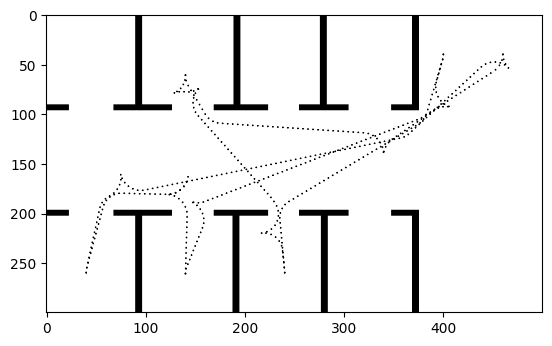

In [11]:
plot_path(result)